In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##import

In [1]:
%tensorflow_version 2.x
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model
import keras
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

##change hyperparameter to make best model

In [2]:
seq_length = 5 # length of sequence for a training example
epoch = 20
MAXLEN = 43
DENSE_HIDDEN_SIZE = 20
train_model_percentage = 80

BATCH_SIZE = 64
ADDRESS_PREDICT_SIZE = 1001
EMBEDDING_DIM = 64
RNN_UNITS = 1024

FIRST_OUTPUT_SIZE = 256
SECOND_OUTPUT_SIZE = 16
FINAL_HIDDEN_SIZE = 128

BUFFER_SIZE = 10000

##open text file

In [3]:
#f = open("473.astar-s0.txt", 'r')
f = open('/content/drive/MyDrive/Colab Notebooks/dataset/473.astar-s0.txt', 'r')

##text file split

In [4]:
unique_instr_id = list()
cycle_count = list()
load_address = list()
instr_pointer_load = list()
llc_hit_miss = list()

f.seek(0, 0)
while True:
  line = f.readline()
  if not line: break
  split_line = line.split(', ')
  unique_instr_id.append(split_line[0])
  cycle_count.append(split_line[1])
  load_address.append(split_line[2])
  instr_pointer_load.append(split_line[3])
  llc_hit_miss.append(split_line[4][:-1])

for i in range(len(load_address)):
  load_address[i] = int(load_address[i], 16)//64

print("\nload_address example: ")
print(load_address[:100])


load_address example: 
[702778646977, 702778647164, 702778646976, 702778646921, 702778647176, 702778647287, 702778647353, 702778647368, 702778647452, 702778647286, 702778647484, 702778647560, 702778647644, 702778647688, 702778647352, 702778647755, 702778647819, 702778647901, 702778647933, 4363500793931, 702778647351, 702778647820, 702778647756, 4363500793932, 4363500794023, 4363500794087, 174026416743, 702778647350, 174026416807, 174026416838, 2627809326406, 2627809326492, 2627809326524, 2627809326534, 2627809326620, 702778647349, 2627809326662, 2627809326780, 2627809326844, 2627809326857, 2627809326889, 2627809326972, 2627809326988, 2627809327052, 2627809327116, 2627809327180, 2627809327277, 2627809327309, 2627809327341, 702778647348, 2627809327115, 2627809327366, 2627809327430, 2627809327532, 2627809327564, 2627809327596, 2627809327622, 2627809327686, 2627809327749, 702778647347, 2627809327813, 2627809327877, 2627809327979, 2627809328011, 2627809328043, 2627809327947, 2627809328069,

##make delta list(first input)

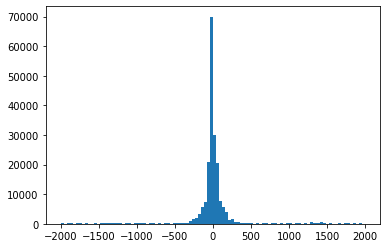


delta example, final delta:
[687, 312, 445, 755, 611, 566, 515, 584, 334, 698, 576, 584, 544, 164, 903, 564, 582, 532, 1000, 0, 969, 436, 1000, 591, 564, 0, 1000, 0, 531, 1000, 586, 532, 510, 586, 0, 1000, 618, 564, 513, 532, 583, 516, 564, 564, 564, 597, 532, 532, 0, 1000, 751, 564, 602, 532, 532, 526, 564, 563, 0, 1000, 564, 602, 532, 532, 404, 622, 564, 0, 1000, 564, 597, 531, 437, 370, 768, 564, 589, 532, 571, 461, 603, 301, 763, 589, 0, 1000, 0, 1000, 1000, 0, 532, 347, 685, 1000, 0, 781, 0, 1000, 563, 501]
585

delta_bundle example:
[[ 687  312  445  755  611  566]
 [ 312  445  755  611  566  515]
 [ 445  755  611  566  515  584]
 ...
 [ 499    0  554  501 1000  499]
 [   0  554  501 1000  499    0]
 [ 554  501 1000  499    0  585]]

first input example(rnn_data): 
[[ 687  312  445  755  611]
 [ 312  445  755  611  566]
 [ 445  755  611  566  515]
 ...
 [ 499    0  554  501 1000]
 [   0  554  501 1000  499]
 [ 554  501 1000  499    0]]


In [5]:
delta = list()
for i in range(len(load_address)-1):
  delta.append(load_address[i+1] - load_address[i])

plot_this = list()
for i in range(len(load_address)-1):
  if delta[i] > 2000:
    continue
  if delta[i] < -2000:
    continue
  plot_this.append(delta[i])
plt.hist(plot_this, bins=100)
plt.show()

for i in range(len(delta)):
  if delta[i] > 500:
    delta[i] = 1000
    continue
  if delta[i] < -500:
    delta[i] = 0
    continue
  delta[i] += 500

print("\ndelta example, final delta:")
print(delta[0:100])
print(delta[-1])

delta_bundle = list()
for i in range(len(delta) - seq_length):
  delta_bundle.append(delta[i:i+seq_length+1])
delta_bundle = np.array(delta_bundle)

print("\ndelta_bundle example:")
print(delta_bundle)

rnn_data = delta_bundle[:,:-1]
rnn_data = np.array(rnn_data)
print("\nfirst input example(rnn_data): ")
print(rnn_data)

##make address binary input(second input)

In [6]:
# 8 -> [0,0,0,1] change int to categorical value
def address_to_binary(a):
  binary_int = list()
  for i in range(MAXLEN):
    # /1000 -> scaling
    binary_int.append(a%2)
    a = a//2
  return binary_int

print("\n8 to binary category:")
print(address_to_binary(8))

address_binary_input = list()
for i in range(seq_length, len(load_address)-1):
  address_binary_input.append(address_to_binary(load_address[i]))

print("\naddress binary input example")
print(address_binary_input[0])
address_binary_input = np.array(address_binary_input)


8 to binary category:
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

address binary input example
[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


##make output data

In [7]:
delta_output = delta_bundle[:,-1:]
delta_output = delta_output.flatten()
print("\noutput example:")
print(delta_output)

print('output shape')
print(rnn_data.shape)
print(address_binary_input.shape)
print(delta_output.shape)


output example:
[566 515 584 ... 499   0 585]
output shape
(721566, 5)
(721566, 43)
(721566,)


##kick dummy input and output

In [8]:
delete_list = list()
for i in range(len(delta_output)):
  if delta_output[i] == 0 or delta_output[i] == 1000:
    delete_list.append(i)

delta_output = np.delete(delta_output, delete_list)
rnn_data = np.delete(rnn_data, delete_list, 0)
address_binary_input = np.delete(address_binary_input, delete_list, 0)

print("\n0 and 1000 removed delta output example:")
print(delta_output)


0 and 1000 removed delta output example:
[566 515 584 ... 501 499 585]


##make train and test data

In [9]:
idx = np.arange(rnn_data.shape[0])
np.random.shuffle(idx)

rnn_data = rnn_data[idx]
address_binary_input = address_binary_input[idx]
delta_output = delta_output[idx]

cut_index = len(rnn_data) * train_model_percentage // 100

train_rnn_data = rnn_data[:cut_index,:]
test_rnn_data = rnn_data[cut_index:]

train_address_binary_input = address_binary_input[:cut_index,:]
test_address_binary_input = address_binary_input[cut_index:,:]

train_delta_output = delta_output[:cut_index]
test_delta_output = delta_output[cut_index:]

## shuffle data

In [10]:
idx = np.arange(train_rnn_data.shape[0])
np.random.shuffle(idx)

train_rnn_data = train_rnn_data[idx]
train_address_binary_input = train_address_binary_input[idx]
train_delta_output = train_delta_output[idx]

idx = np.arange(test_rnn_data.shape[0])
np.random.shuffle(idx)

test_rnn_data = test_rnn_data[idx]
test_address_binary_input = test_address_binary_input[idx]
test_delta_output = test_delta_output[idx]

##make model

In [11]:
def build_model(address_predict_size, first_output_size, second_output_size, final_hidden_size, embedding_dim, rnn_units):
  
  input_x = Input(shape=(seq_length,))
  x = Embedding(address_predict_size, embedding_dim)(input_x)
  x = LSTM(rnn_units, recurrent_initializer='glorot_uniform') (x)
  x = Dense(first_output_size, activation="sigmoid") (x)
  x = Model(inputs=input_x, outputs=x)

  input_y = Input(shape=(MAXLEN,))
  y = Dense(second_output_size, activation="relu")(input_y)
  y = Model(inputs=input_y, outputs=y)

  combined = tf.keras.layers.concatenate([x.output, y.output])

  z = Dense(final_hidden_size, activation="relu")(combined)
  z = Dense(address_predict_size, activation="sigmoid")(z)

  model = Model(inputs=[x.input, y.input], outputs=z)

  return model

model = build_model(ADDRESS_PREDICT_SIZE, FIRST_OUTPUT_SIZE, SECOND_OUTPUT_SIZE, FINAL_HIDDEN_SIZE, EMBEDDING_DIM, RNN_UNITS)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 64)        64064       input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 1024)         4460544     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 43)]         0                                            
____________________________________________________________________________________________

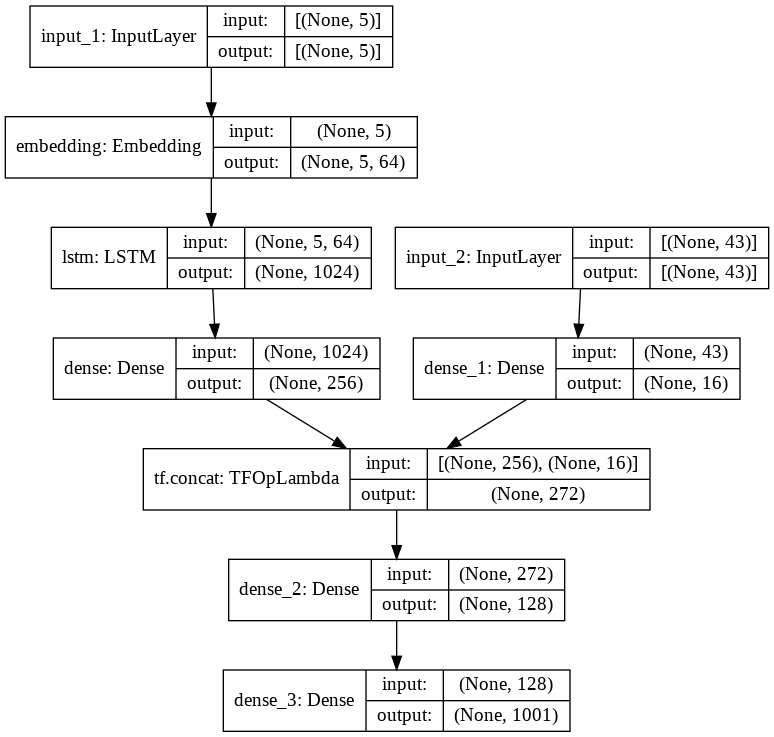

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

##create loss function

In [13]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits)

In [14]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [15]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [16]:
history = model.fit([train_rnn_data, train_address_binary_input], train_delta_output, batch_size=BATCH_SIZE, epochs=epoch, callbacks=[checkpoint_callback])

Epoch 1/20
2322/2322 [==============================] - 37s 8ms/step - loss: 3.5703 - accuracy: 0.3878
Epoch 2/20
2322/2322 [==============================] - 18s 8ms/step - loss: 3.0511 - accuracy: 0.4461
Epoch 3/20
2322/2322 [==============================] - 18s 8ms/step - loss: 2.8717 - accuracy: 0.4547
Epoch 4/20
2322/2322 [==============================] - 18s 8ms/step - loss: 2.7034 - accuracy: 0.4637
Epoch 5/20
2322/2322 [==============================] - 18s 8ms/step - loss: 2.5526 - accuracy: 0.4746
Epoch 6/20
2322/2322 [==============================] - 18s 8ms/step - loss: 2.3956 - accuracy: 0.4885
Epoch 7/20
2322/2322 [==============================] - 18s 8ms/step - loss: 2.2709 - accuracy: 0.5014
Epoch 8/20
2322/2322 [==============================] - 19s 8ms/step - loss: 2.1639 - accuracy: 0.5151
Epoch 9/20
2322/2322 [==============================] - 18s 8ms/step - loss: 2.0430 - accuracy: 0.5358
Epoch 10/20
2322/2322 [==============================] - 18s 8ms/step - l

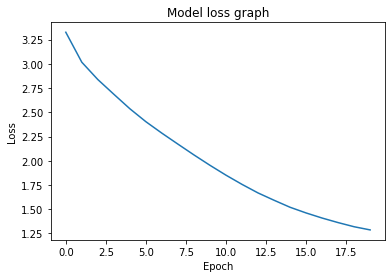

In [17]:
plt.plot(history.history['loss'])
plt.title('Model loss graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

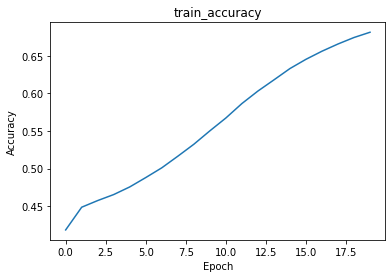

0.6813241243362427


In [18]:
plt.plot(history.history['accuracy'])
plt.title('train_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

print(history.history['accuracy'][-1])

In [19]:
def generate_address(model, start_address):
  # Evaluation step (generating address using the learned model)

  # Number of characters to generate
  num_generate = 2

  input_eval = [tf.expand_dims(start_address[0], 0), tf.expand_dims(start_address[1], 0)]

  # Empty string to store our results
  generated = []

  # Low temperatures results in more predictable.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  
  predictions = model(input_eval)

  predictions = predictions / temperature

  # using probability
  '''
  generated = tf.random.categorical(predictions_np, num_samples=num_generate)[-1,0].numpy()  
  '''

  # using argmax
  predictions_np = predictions.numpy()
  predictions_np = np.squeeze(predictions_np,axis=0)
  predictions_np = np.argsort(predictions_np)
  generated = predictions_np [-num_generate:]

  return generated

##accuracy 측정

In [ ]:
total_num_except_0_1000 = len(test_rnn_data)
correct = 0
first_correct = 0
second_correct = 0

for i in tqdm(range(len(test_delta_output)), desc='check accuracy..'):
  inp = [test_rnn_data[i].tolist(), test_address_binary_input[i].tolist()]
  lstm_ans = generate_address(model, inp)
  if test_delta_output[i] in lstm_ans:
    correct += 1
    if test_delta_output[i] == lstm_ans[0]:
      first_correct += 1
    if test_delta_output[i] == lstm_ans[1]:
      second_correct += 1

print("\naccuracy except 0 and 1000")
print(correct/total_num_except_0_1000)
print("first number accuracy")
print(first_correct/total_num_except_0_1000)
print("second number accuracy")
print(second_correct/total_num_except_0_1000)

check accuracy..:  83%|████████▎ | 31016/37149 [03:30<00:42, 143.74it/s]

https://jaehyeongan.github.io/2019/03/26/KERAS-FUNCTIONAL-API-MULTI-INPUT-%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%B6%95%ED%95%98%EA%B8%B0/

https://gooopy.tistory.com/103?category=876252